In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
plt.style.use('seaborn-whitegrid')

from utils import PkdbModel, ccolors ,markers,category_filter_medication_or_oc,category_filter_oc,filter_df,\
    abs_idx,rel_idx,group_idx,individual_idx \

plt.rcParams.update({
        'axes.labelsize': '20',
        'axes.labelweight': 'bold',
        'axes.titlesize': 'medium',
        'axes.titleweight': 'bold',
        'legend.fontsize': '20',
        'xtick.labelsize': '20',
        'ytick.labelsize': '20',
        'figure.facecolor': '1.00'
    })


In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
caffeine_clr = PkdbModel("caffeine_clearance",destination="3-inferred")
caffeine_clr.read()
caffeine_clearance = caffeine_clr.data
caffeine_clearance.groupby("study")

In [14]:
caffeine_clearance["outlier"] = False
caffeine_clearance.loc[caffeine_clearance["study"]== "Balogh1992","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1988","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1989","outlier"] = True

In [16]:
#= len(caffeine_clearance) ( 
#(('medication','choice'),('medication','choice')):('Y','N'),)

In [23]:
#caffeine_clearance=caffeine_clearance.groupby("study").get_group("Park2003")
# caffeine clearance
def create_plots(df, category_filter,fig_path):
    fig1, ax1, = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))
    fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))
    fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))
    fig4, ax4 = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))

    dinds = [abs_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit"),
             rel_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit"),
             abs_idx(caffeine_clearance,"unit_intervention") & rel_idx(caffeine_clearance,"unit"),
             rel_idx(caffeine_clearance,"unit_intervention") & rel_idx(caffeine_clearance,"unit")]

    for ax, inds in zip((ax1, ax2, ax3, ax4), dinds):
        df = caffeine_clearance[inds & individual_idx(caffeine_clearance)]
        df_group = caffeine_clearance[inds & group_idx(caffeine_clearance)]

        for category in ccolors:
            cf_filter = category_filter[category]
            df_category = filter_df(cf_filter,df)
            x = df_category["value_intervention"]
            y = df_category["value"]
            ax.scatter(x, y,color=ccolors[category], marker=markers[category], alpha=0.5,label=None,  s=20)
            units = df_category["unit"].unique()
            unit_intervention = df_category["unit_intervention"].unique()

            assert len(units) <= 1, units
            try:
                ax.set_ylabel(f'caffeine clearance [{units[0]}]')
                ax.set_xlabel(f'caffeine dose [{unit_intervention[0]}]')
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

            except IndexError: 
                pass

            df_category = filter_df(cf_filter,df_group)
            df_category = df_category[df_category["mean"].notnull()]
            x_group = df_category["value_intervention"]
            y_group = df_category["mean"]
            
            if ax in (ax2, ax4):
                xerr_group = (df_category[("weight","sd")]/df_category[("weight","mean")])*x_group
            else:
                xerr_group = 0
            yerr_group = df_category["se"]

            ax.errorbar(x_group, y_group,yerr=yerr_group,xerr=xerr_group,color=ccolors[category], fmt=markers[category],  label=f"{category}(Individuals.:{len(x)},Groups:{len(x_group)})",ms=10, alpha=0.7)
            for i, txt in enumerate(df_category[('study', '')]):
                ax.annotate(txt, (x_group.iloc[[i]]+(0.01*x_group.max()),
                                  y_group.iloc[[i]]+(0.01*y_group.max())), alpha=0.7)

    for ax in (ax1, ax2, ax3, ax4):

        ax.set_title('Clearance')
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
        ax.legend()
        
    fig1.savefig(os.path.join(fig_path,"cleaence_abs-vs-dosing_abs.svg"), bbox_inches="tight")
    fig2.savefig(os.path.join(fig_path,"cleaence_rel-vs-dosing_abs.svg"), bbox_inches="tight")
    fig3.savefig(os.path.join(fig_path,"cleaence_abs-vs-dosing_rel.svg"), bbox_inches="tight")
    fig4.savefig(os.path.join(fig_path,"cleaence_rel-vs-dosing_rel.svg"), bbox_inches="tight")


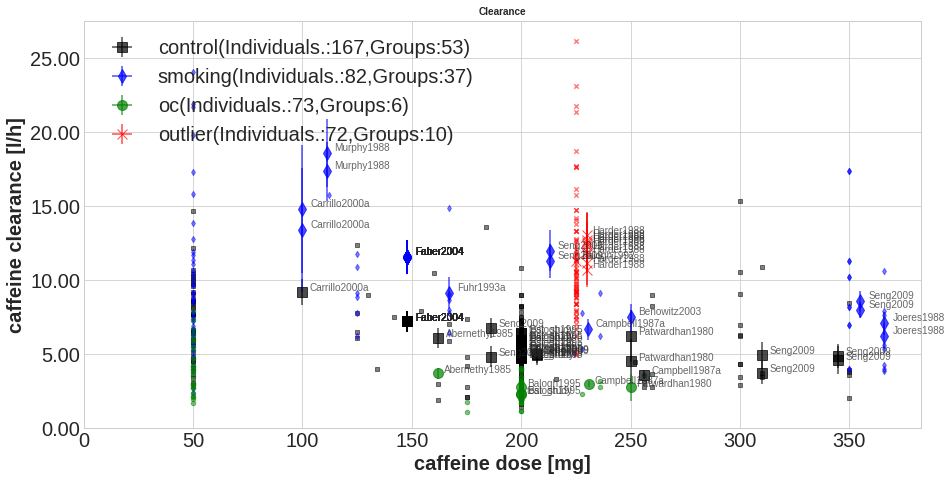

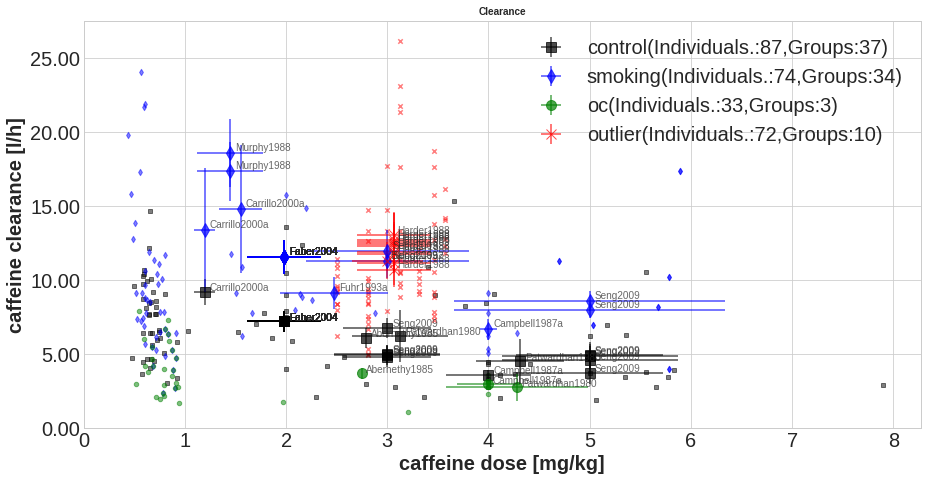

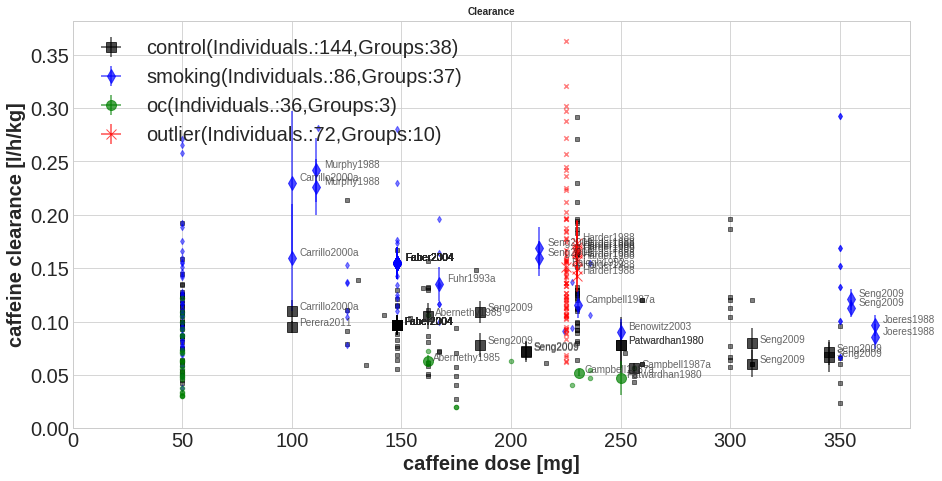

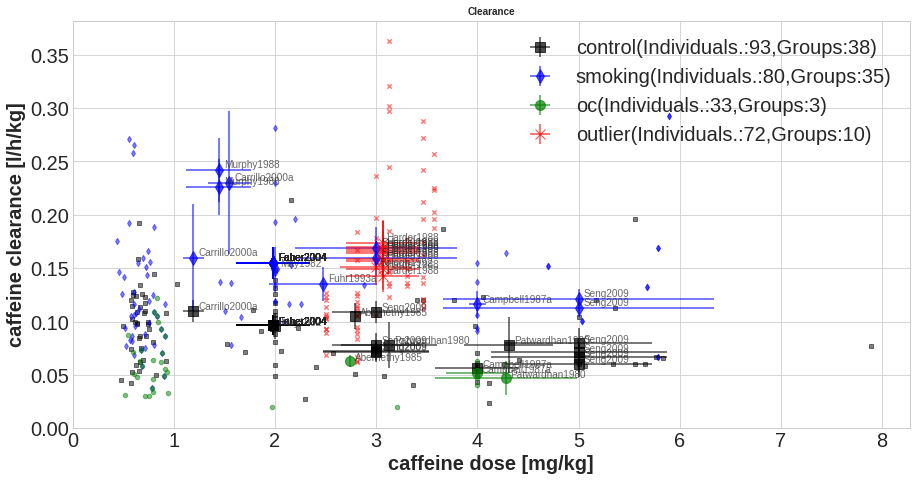

In [27]:
create_plots(caffeine_clearance,category_filter_oc,"./reports/oral_contraceptices")

In [ ]:
create_plots(caffeine_clearance,category_filter_medication_or_oc,"./reports/medication_or_oc")